In [ ]:
!wget https://zenodo.org/records/15613160/files/Na.vasp
!wget https://zenodo.org/records/15613160/files/Na55_rho_ks.xsf
!wget https://zenodo.org/records/15613160/files/Na55_rho_lmg.xsf
!wget https://zenodo.org/records/15613160/files/Na55.tddft.out

## Visualize structure with ASE

In [2]:
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from io import BytesIO
from ase.io import read
import numpy as np
import matplotlib.pyplot as plt

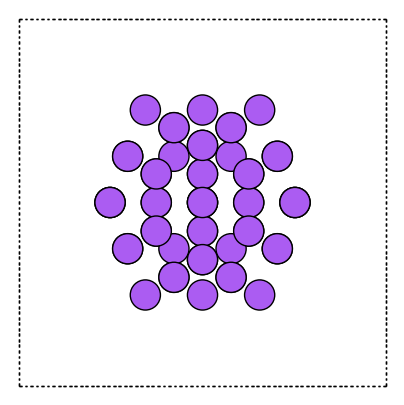

In [3]:
atoms = read('Na.vasp')
fig, ax = plt.subplots(figsize=(5, 5))
plot_atoms(atoms, ax, radii=0.5, rotation=('90x,90y,0z'))
plt.axis('off')
buf = BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)
fig.savefig('Na55.png')

In [4]:
from dftpy.formats import io
rho_ks = io.read_density('Na55_rho_ks.xsf', full=True)
rho_lmgp = io.read_density('Na55_rho_lmgp.xsf', full=True)

In [5]:
rho_ks.grid.nr, rho_lmgp.grid.nr

(array([180, 180, 180]), array([36, 36, 36]))

In [6]:
from dftpy.grid import DirectGrid
from dftpy.utils import grid_map_data
grid = DirectGrid(rho_lmgp.grid.lattice, nr=rho_lmgp.grid.nr)
rho_ks = grid_map_data(rho_ks, grid=grid)

In [7]:
0.5 * (np.abs(rho_ks-rho_lmgp)).integral()

3.815897860834287

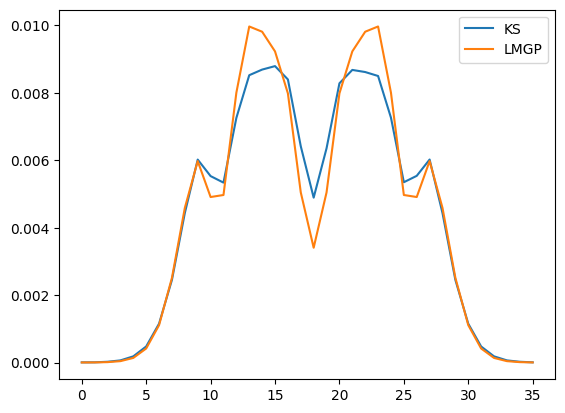

In [8]:
plt.plot(rho_ks[15,15,:].ravel(), label='KS')
plt.plot(rho_lmgp[15,15,:].ravel(), label='LMGP')
plt.legend()

In [9]:

from dftpy.td.utils import calc_spectra_mu
import qepy
from dftpy.constants import TIME_CONV, LEN_CONV, ENERGY_CONV
as2au = TIME_CONV['s']['au']*1e-18
bohr = LEN_CONV['Angstrom']['Bohr']
k = 0.01*bohr
interval = 1.0 * as2au
ha = ENERGY_CONV['Hartree']['eV']

In [10]:
direction = 0 # 0, 1, 2 means x, y, z-direction, respectively
k = 0.01*bohr # kick_strength in a.u.
interval = 1.0 * as2au
output = 'Na55.tddft.out'

In [11]:
mu = []
with open(output, 'r') as fh:
    for line in fh:
        if line[:4]=='DIP ':
            mu.append(list(map(float, line.split()[-3:])))
mu = np.asarray(mu)

Text(0, 0.5, 'Dipole Moment (au)')

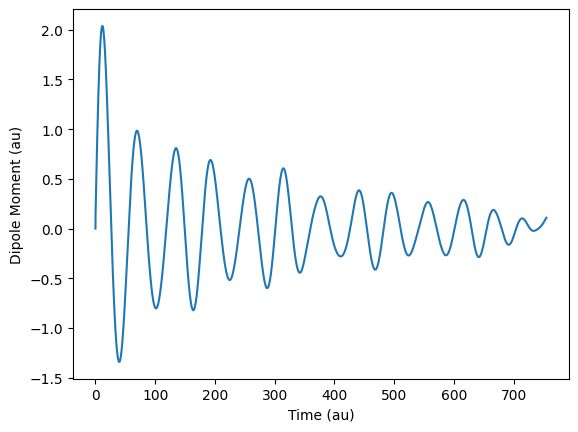

In [12]:
max_steps = len(mu)-1
t = np.linspace(0, interval * max_steps, max_steps + 1)
delta_mu = mu[:,0] - mu[0,0]
plt.plot(t, delta_mu)
plt.xlabel('Time (au)')
plt.ylabel('Dipole Moment (au)')

In [13]:
max_steps, 0.02*(as2au**2)

(18251, 3.418218299967324e-05)

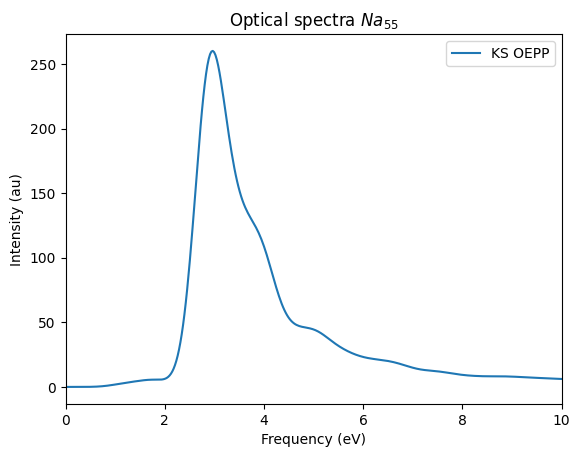

In [14]:
sigma = 0.03*(as2au**2)
omega, spectra = calc_spectra_mu(delta_mu, interval, kick=k, emax=2, sigma=sigma)
plt.plot(omega*ha, spectra, '-', label='KS OEPP')
plt.xlabel('Frequency (eV)')
plt.ylabel('Intensity (au)')
plt.xlim(0, 10)
plt.title(r'Optical spectra $Na_{55}$')
plt.legend()